# Imports

In [1]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import layers, models, optimizers
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split, KFold
import keras_tuner as kt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# LeNet-5

## Criação do modelo

In [2]:
# Diretório que contém as pastas Training e Testing
data_dir = r'C:\Users\Willi\OneDrive\Área de Trabalho\tcc\archive (2)'

# Listando os diretórios de treinamento e teste
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')

# Carregando as imagens e retornando os caminhos dos arquivos e rótulos
def load_images_from_directory(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            images.append(img_path)
            labels.append(label)
    return images, labels

# Carregando imagens e rótulos de treinamento
train_images, train_labels = load_images_from_directory(train_dir)

# Carregando imagens e rótulos de teste
test_images, test_labels = load_images_from_directory(test_dir)

# Dividindo os dados de treinamento em treinamento e validação
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Codificando os rótulos com LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

# Convertendo rótulos para tipo inteiro
train_labels = train_labels_encoded.astype(int)
val_labels = val_labels_encoded.astype(int)

# Exibindo as informações dos dados
print("Número de imagens de treinamento:", len(train_images))
print("Número de imagens de validação:", len(val_images))
print("Número de imagens de teste:", len(test_images))

Número de imagens de treinamento: 4569
Número de imagens de validação: 1143
Número de imagens de teste: 1311


In [3]:
# Carregar e pré-processar imagens de validação
def load_images_from_paths(image_paths):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=(32, 32))
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        images.append(img_array)
    return np.array(images)

val_images_processed = load_images_from_paths(val_images)

# Verificar o formato das imagens de validação processadas
print("Formato das imagens de validação:", val_images_processed.shape)
print("Tipo das imagens de validação:", val_images_processed.dtype)

Formato das imagens de validação: (1143, 32, 32, 3)
Tipo das imagens de validação: float32


In [10]:
# Função para definir a arquitetura da LeNet-5
def LeNet5(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# Definindo as variáveis input_shape e num_classes
input_shape = (32, 32, 3)
num_classes = 4

# Aplicando a validação cruzada K-Fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_indices, val_indices) in enumerate(kfold.split(train_images)):
    print(f"Fold {fold + 1}")
    fold_train_images = [train_images[i] for i in train_indices]
    fold_train_labels = [train_labels[i] for i in train_indices]
    fold_val_images = [train_images[i] for i in val_indices]
    fold_val_labels = [train_labels[i] for i in val_indices]
    
    # Carregar e pré-processar imagens de treinamento e validação
    fold_train_images_processed = []
    fold_val_images_processed = []
    for img_path in fold_train_images:
        img = load_img(img_path, target_size=(32, 32))
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        fold_train_images_processed.append(img_array)
    for img_path in fold_val_images:
        img = load_img(img_path, target_size=(32, 32))
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        fold_val_images_processed.append(img_array)
    
    fold_train_images_processed = np.array(fold_train_images_processed)
    fold_val_images_processed = np.array(fold_val_images_processed)
    
    # Codificar rótulos
    label_encoder = LabelEncoder()
    fold_train_labels_encoded = label_encoder.fit_transform(fold_train_labels)
    fold_val_labels_encoded = label_encoder.transform(fold_val_labels)
    
    # Converter rótulos para tipo inteiro
    fold_train_labels = fold_train_labels_encoded.astype(int)
    fold_val_labels = fold_val_labels_encoded.astype(int)
    
    # Definindo a arquitetura da LeNet-5 para cada fold
    model = LeNet5(input_shape, num_classes)
    
    # Compilando o modelo
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Treinamento do modelo para cada fold
    model.fit(x=fold_train_images_processed, y=fold_train_labels,
              validation_data=(fold_val_images_processed, fold_val_labels),
              epochs=10, batch_size=32)

Fold 1
Epoch 1/10


c:\Users\Willi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4445 - loss: 1.1550 - val_accuracy: 0.7210 - val_loss: 0.7087
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7421 - loss: 0.6653 - val_accuracy: 0.7877 - val_loss: 0.5695
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7915 - loss: 0.5268 - val_accuracy: 0.8042 - val_loss: 0.5230
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8130 - loss: 0.4766 - val_accuracy: 0.7823 - val_loss: 0.5383
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8470 - loss: 0.4054 - val_accuracy: 0.8414 - val_loss: 0.4317
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8587 - loss: 0.3624 - val_accuracy: 0.8381 - val_loss: 0.4325
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8827 - loss: 0.3159 - val_accuracy: 0.8468 - val_loss: 0.4150
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8820 - loss: 0.3076 - val_accuracy: 0.8545 - val

c:\Users\Willi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4143 - loss: 1.1771 - val_accuracy: 0.7352 - val_loss: 0.7043
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7324 - loss: 0.6897 - val_accuracy: 0.7998 - val_loss: 0.5447
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7665 - loss: 0.5757 - val_accuracy: 0.8282 - val_loss: 0.4628
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8223 - loss: 0.4799 - val_accuracy: 0.8107 - val_loss: 0.4985
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8337 - loss: 0.4370 - val_accuracy: 0.8534 - val_loss: 0.4006
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8539 - loss: 0.3854 - val_accuracy: 0.8556 - val_loss: 0.3819
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8742 - loss: 0.3341 - val_accuracy: 0.8600 - val_loss: 0.3714
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8719 - loss: 0.3360 - val_accuracy: 0.8151 - val_

c:\Users\Willi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4271 - loss: 1.2004 - val_accuracy: 0.7396 - val_loss: 0.7203
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7518 - loss: 0.6552 - val_accuracy: 0.7910 - val_loss: 0.5931
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8089 - loss: 0.5059 - val_accuracy: 0.8031 - val_loss: 0.5067
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8294 - loss: 0.4418 - val_accuracy: 0.8249 - val_loss: 0.4548
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8596 - loss: 0.3828 - val_accuracy: 0.8326 - val_loss: 0.4338
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8773 - loss: 0.3302 - val_accuracy: 0.8534 - val_loss: 0.4088
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8757 - loss: 0.3297 - val_accuracy: 0.8468 - val_loss: 0.3912
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8979 - loss: 0.2666 - val_accuracy: 0.8807 - val_

c:\Users\Willi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4154 - loss: 1.2100 - val_accuracy: 0.6991 - val_loss: 0.8172
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7604 - loss: 0.6519 - val_accuracy: 0.7702 - val_loss: 0.5717
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8053 - loss: 0.5232 - val_accuracy: 0.8020 - val_loss: 0.5526
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8443 - loss: 0.4089 - val_accuracy: 0.8118 - val_loss: 0.5070
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8529 - loss: 0.3879 - val_accuracy: 0.8337 - val_loss: 0.4761
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8808 - loss: 0.3175 - val_accuracy: 0.8217 - val_loss: 0.4688
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8989 - loss: 0.2693 - val_accuracy: 0.8392 - val_loss: 0.4206
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8837 - loss: 0.2959 - val_accuracy: 0.8545 - val

c:\Users\Willi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4620 - loss: 1.1504 - val_accuracy: 0.6911 - val_loss: 0.7987
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7406 - loss: 0.6921 - val_accuracy: 0.7809 - val_loss: 0.5396
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7976 - loss: 0.5258 - val_accuracy: 0.8094 - val_loss: 0.4745
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8304 - loss: 0.4353 - val_accuracy: 0.8324 - val_loss: 0.4313
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8586 - loss: 0.3846 - val_accuracy: 0.8423 - val_loss: 0.3872
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8417 - loss: 0.3901 - val_accuracy: 0.8105 - val_loss: 0.4563
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8708 - loss: 0.3133 - val_accuracy: 0.8587 - val_loss: 0.3700
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9013 - loss: 0.2752 - val_accuracy: 0.8412 - val_

In [15]:
def LeNet5(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# Definindo as variáveis input_shape e num_classes
input_shape = (32, 32, 3)
num_classes = 4

# Aplicando a validação cruzada K-Fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Escolhendo o fold desejado
chosen_fold = 3

for fold, (train_indices, val_indices) in enumerate(kfold.split(train_images)):
    if fold == chosen_fold:
        print(f"Fold {fold}")
        fold_train_images = [train_images[i] for i in train_indices]
        fold_train_labels = [train_labels[i] for i in train_indices]
        fold_val_images = [train_images[i] for i in val_indices]
        fold_val_labels = [train_labels[i] for i in val_indices]

        # Carregar e pré-processar imagens de treinamento e validação
        fold_train_images_processed = []
        fold_val_images_processed = []
        for img_path in fold_train_images:
            img = load_img(img_path, target_size=(32, 32))
            img_array = img_to_array(img)
            img_array = img_array / 255.0
            fold_train_images_processed.append(img_array)
        for img_path in fold_val_images:
            img = load_img(img_path, target_size=(32, 32))
            img_array = img_to_array(img)
            img_array = img_array / 255.0
            fold_val_images_processed.append(img_array)

        fold_train_images_processed = np.array(fold_train_images_processed)
        fold_val_images_processed = np.array(fold_val_images_processed)

        # Codificar rótulos
        label_encoder = LabelEncoder()
        fold_train_labels_encoded = label_encoder.fit_transform(fold_train_labels)
        fold_val_labels_encoded = label_encoder.transform(fold_val_labels)

        # Converter rótulos para tipo inteiro
        fold_train_labels = fold_train_labels_encoded.astype(int)
        fold_val_labels = fold_val_labels_encoded.astype(int)

        # Definindo a arquitetura da LeNet-5 para cada fold
        model = LeNet5(input_shape, num_classes)

        # Compilando o modelo
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        # Treinamento do modelo para cada fold
        model.fit(x=fold_train_images_processed, y=fold_train_labels,
                  validation_data=(fold_val_images_processed, fold_val_labels),
                  epochs=10, batch_size=32)

Fold 3
Epoch 1/10


c:\Users\Willi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4109 - loss: 1.1940 - val_accuracy: 0.7046 - val_loss: 0.6956
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7641 - loss: 0.6375 - val_accuracy: 0.7713 - val_loss: 0.5822
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8109 - loss: 0.5045 - val_accuracy: 0.8096 - val_loss: 0.5051
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8388 - loss: 0.4284 - val_accuracy: 0.7987 - val_loss: 0.4915
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8541 - loss: 0.3875 - val_accuracy: 0.8260 - val_loss: 0.4297
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8664 - loss: 0.3575 - val_accuracy: 0.8217 - val_loss: 0.4384
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8882 - loss: 0.3047 - val_accuracy: 0.8184 - val_loss: 0.4539
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9095 - loss: 0.2624 - val_accuracy: 0.8687 - val_

In [11]:
# Salvar o modelo treinado
model.save('LeNet5Kfold_model.keras')

In [4]:
# Carregar o modelo treinado
LeNet5ModelKfold = load_model('LeNet5Kfold_model.keras')

In [13]:
# Carregando a imagem que para classificar
img_path = r"C:\Users\Willi\OneDrive\Área de Trabalho\tcc\archive (2)\Testing\pituitary\Te-pi_0054.jpg"
img = image.load_img(img_path, target_size=(32, 32))
img_array = image.img_to_array(img)
img_array = img_array / 255.0

# Adicionando uma dimensão extra para se adequar ao formato esperado pelo modelo
img_array = np.expand_dims(img_array, axis=0)

# Fazendo a previsão usando o modelo
predictions = LeNet5ModelKfold.predict(img_array)

# Índice com maior probabilidade
predicted_class = np.argmax(predictions)

# Classe prevista
if predicted_class == 0:
    print("Classe Glioma:", predicted_class)
elif predicted_class == 1:
    print("Classe Meningioma:", predicted_class)
elif predicted_class == 2:
    print("Classe Notumor:", predicted_class)
elif predicted_class == 3:
    print("Classe Pituary:", predicted_class)
else:
    print('Classe não encontrada')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Classe Pituary: 3


## Análise da acurácia

In [5]:
# Carregar e pré-processar imagens de treinamento
train_images_processed = load_images_from_paths(train_images)

# Fazer a previsão do conjunto de validação
train_predictions = LeNet5ModelKfold.predict(train_images_processed)
train_predictions_classes = np.argmax(train_predictions, axis=1)

# Calcular a acurácia
accuracy = accuracy_score(train_labels, train_predictions_classes)
print("Acurácia:", accuracy)

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Acurácia: 0.9268986649157365


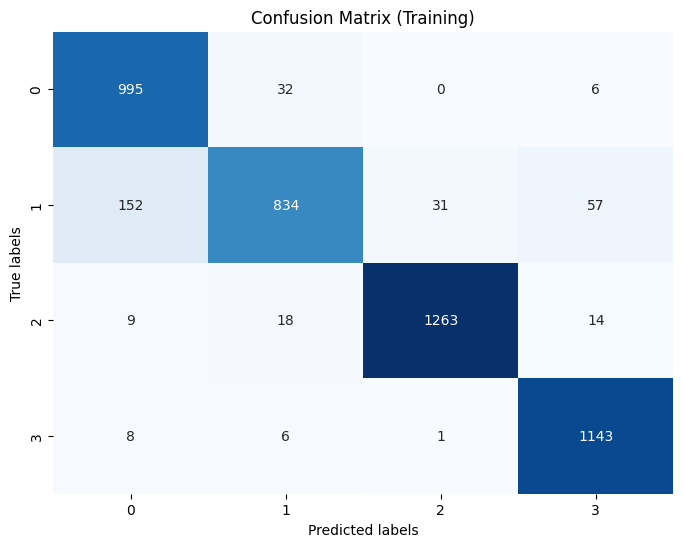

In [6]:
# Matriz de confusão
conf_matrix = confusion_matrix(train_labels, train_predictions_classes)

# Exibir a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Training)')
plt.show()

In [8]:
# Precisão, recall e F1-score
report = classification_report(train_labels, train_predictions_classes, target_names=label_encoder.classes_)
print("Relatório de Classificação:")
print(report)

Relatório de Classificação:
              precision    recall  f1-score   support

      glioma       0.85      0.96      0.91      1033
  meningioma       0.94      0.78      0.85      1074
     notumor       0.98      0.97      0.97      1304
   pituitary       0.94      0.99      0.96      1158

    accuracy                           0.93      4569
   macro avg       0.93      0.92      0.92      4569
weighted avg       0.93      0.93      0.93      4569



# AlexNet

## Criação do modelo

In [2]:
# Diretório que contém as pastas Training e Testing
data_dir = r'C:\Users\Willi\OneDrive\Área de Trabalho\tcc\archive (2)'

# Listando os diretórios de treinamento e teste
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')

# Carregando as imagens e retornando os caminhos dos arquivos e rótulos
def load_images_from_directory(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            images.append(img_path)
            labels.append(label)
    return images, labels

# Carregando imagens e rótulos de treinamento
train_images, train_labels = load_images_from_directory(train_dir)

# Carregando imagens e rótulos de teste
test_images, test_labels = load_images_from_directory(test_dir)

# Dividindo os dados de treinamento em treinamento e validação
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Codificando os rótulos com LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

# Convertendo rótulos para tipo inteiro
train_labels = train_labels_encoded.astype(int)
val_labels = val_labels_encoded.astype(int)

# Exibindo as informações dos dados
print("Número de imagens de treinamento:", len(train_images))
print("Número de imagens de validação:", len(val_images))
print("Número de imagens de teste:", len(test_images))

Número de imagens de treinamento: 4569
Número de imagens de validação: 1143
Número de imagens de teste: 1311


In [3]:
# Função para pré-processar imagens
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(227, 227))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    return img_array

# Função para pré-processar um lote de imagens
def preprocess_images_in_batches(image_paths, batch_size=32):
    images_processed = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = [preprocess_image(image_path) for image_path in batch_paths]
        images_processed.extend(batch_images)
    return np.array(images_processed)

# Exibindo as informações dos dados
batch_size = 32
train_images_processed = preprocess_images_in_batches(train_images, batch_size=batch_size)
val_images_processed = preprocess_images_in_batches(val_images, batch_size=batch_size)
test_images_processed = preprocess_images_in_batches(test_images, batch_size=batch_size)
train_images_processed = preprocess_images_in_batches(train_images, batch_size=batch_size)

In [8]:
# Tamanho das imagens
input_shape = (227, 227, 3)

# Número de classes
num_classes = len(label_encoder.classes_)

# Função para pré-processar imagens
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(227, 227))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    return img_array

# Função para pré-processar um lote de imagens
def preprocess_images_in_batches(image_paths, batch_size=32):
    images_processed = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = [preprocess_image(image_path) for image_path in batch_paths]
        images_processed.extend(batch_images)
    return np.array(images_processed)

# Exibindo as informações dos dados
batch_size = 32
train_images_processed = preprocess_images_in_batches(train_images, batch_size=batch_size)
val_images_processed = preprocess_images_in_batches(val_images, batch_size=batch_size)
test_images_processed = preprocess_images_in_batches(test_images, batch_size=batch_size)

# Definindo o modelo AlexNet
def AlexNet(input_shape, num_classes):
    model = models.Sequential()
    
    model.add(layers.Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Aplicando o K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Lista para armazenar as métricas de cada fold
accuracy_per_fold = []

# Iterando sobre os folds
for fold, (train_indices, val_indices) in enumerate(kfold.split(train_images_processed)):
    print(f"Fold {fold + 1}")
    
    # Separando os dados de treinamento e validação para este fold
    fold_train_images = train_images_processed[train_indices]
    fold_train_labels = train_labels_encoded[train_indices]
    fold_val_images = train_images_processed[val_indices]
    fold_val_labels = train_labels_encoded[val_indices]
    
    # Criando uma nova instância do modelo para cada fold
    model = AlexNet(input_shape, num_classes)
    
    # Compilando o modelo
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Treinando o modelo para este fold
    model.fit(x=fold_train_images, y=fold_train_labels, validation_data=(fold_val_images, fold_val_labels), epochs=10, batch_size=32)

Fold 1


c:\Users\Willi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.5352 - loss: 5.0689 - val_accuracy: 0.2429 - val_loss: 3.3616
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.7653 - loss: 0.6396 - val_accuracy: 0.4978 - val_loss: 1.8671
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.7631 - loss: 0.6496 - val_accuracy: 0.6324 - val_loss: 1.3004
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.7618 - loss: 0.6778 - val_accuracy: 0.8195 - val_loss: 0.5112
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.8398 - loss: 0.4466 - val_accuracy: 0.6849 - val_loss: 0.7787
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.8392 - loss: 0.4378 - val_accuracy: 0.7560 - val_loss: 0.6462
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.8576 - loss: 0.4035 - val_accuracy: 0.6368 - val_loss: 0.9498
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.8475 - loss: 0.4357 - val_accu

In [9]:
# Definindo o modelo AlexNet
def AlexNet(input_shape, num_classes):
    model = models.Sequential()
    
    model.add(layers.Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Divisão dos dados de acordo com o fold escolhido
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

chosen_fold = 1

for fold, (train_indices, val_indices) in enumerate(kfold.split(train_images_processed)):
    if fold == chosen_fold:
        fold_train_images = train_images_processed[train_indices]
        fold_train_labels = train_labels_encoded[train_indices]
        fold_val_images = train_images_processed[val_indices]
        fold_val_labels = train_labels_encoded[val_indices]
        break

# Criando uma nova instância do modelo AlexNet
model = AlexNet(input_shape=(227, 227, 3), num_classes=num_classes)

# Compilando o modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Treinando o modelo com os dados do fold escolhido
model.fit(x=fold_train_images, y=fold_train_labels,
          validation_data=(fold_val_images, fold_val_labels),
          epochs=10, batch_size=32)

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.5384 - loss: 6.0490 - val_accuracy: 0.1958 - val_loss: 12.4537
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.6121 - loss: 1.0913 - val_accuracy: 0.5733 - val_loss: 1.1762
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.7183 - loss: 0.7936 - val_accuracy: 0.5766 - val_loss: 1.0180
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.7332 - loss: 0.7488 - val_accuracy: 0.7757 - val_loss: 0.5717
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.7701 - loss: 0.6583 - val_accuracy: 0.6937 - val_loss: 0.7486
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.8070 - loss: 0.5717 - val_accuracy: 0.7462 - val_loss: 0.6232
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.8174 - loss: 0.5414 - val_accuracy: 0.2757 - val_loss: 9.6652
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.7988 - loss: 0.5944 - val_acc

In [10]:
# Salvar o modelo treinado
model.save('AlexNetKfold_model.keras')

In [4]:
# Carregar o modelo treinado
AlexNetKfold = load_model("AlexNetKfold_model.keras")

In [14]:
# Carregando a imagem que para classificar
img_path = r"C:\Users\Willi\OneDrive\Área de Trabalho\tcc\archive (2)\Testing\glioma\Te-gl_0019.jpg"
img = image.load_img(img_path, target_size=(227, 227))
img_array = image.img_to_array(img)
img_array = img_array / 255.0

# Adicionando uma dimensão extra para se adequar ao formato esperado pelo modelo
img_array = np.expand_dims(img_array, axis=0)

# Fazendo a previsão usando o modelo
predictions = AlexNetKfold.predict(img_array)

# Índice com maior probabilidade
predicted_class = np.argmax(predictions)

# Classe prevista
if predicted_class == 0:
    print("Classe Glioma:", predicted_class)
elif predicted_class == 1:
    print("Classe Meningioma:", predicted_class)
elif predicted_class == 2:
    print("Classe Notumor:", predicted_class)
elif predicted_class == 3:
    print("Classe Pituary:", predicted_class)
else:
    print('Classe não encontrada')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Classe Notumor: 2


## Análise da acurácia

In [12]:
# Fazer previsões usando o modelo AlexNet nos dados de treinamento
train_predictions = AlexNetKfold.predict(train_images_processed)
train_predictions_classes = np.argmax(train_predictions, axis=1)

# Calcular a acurácia
accuracy_train = accuracy_score(train_labels, train_predictions_classes)
print("Acurácia (Training):", accuracy_train)

143/143 ━━━━━━━━━━━━━━━━━━━━ 63s 377ms/step
Acurácia (Training): 0.2856204858831254


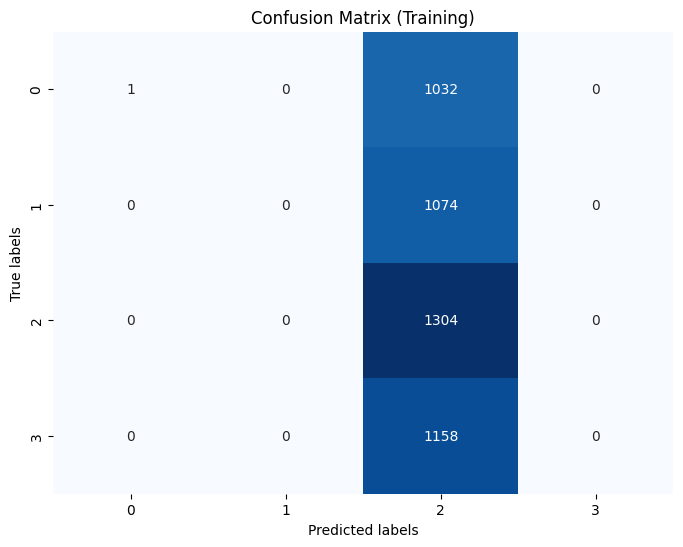

In [13]:
# Matriz de confusão
conf_matrix = confusion_matrix(train_labels, train_predictions_classes)

# Exibir a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Training)')
plt.show()

In [14]:
# Precisão, recall e F1-score
report = classification_report(train_labels, train_predictions_classes, target_names=label_encoder.classes_)
print("Relatório de Classificação:")
print(report)

Relatório de Classificação:
              precision    recall  f1-score   support

      glioma       1.00      0.00      0.00      1033
  meningioma       0.00      0.00      0.00      1074
     notumor       0.29      1.00      0.44      1304
   pituitary       0.00      0.00      0.00      1158

    accuracy                           0.29      4569
   macro avg       0.32      0.25      0.11      4569
weighted avg       0.31      0.29      0.13      4569



c:\Users\Willi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Willi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Willi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# ResNet

## Criação do modelo

In [17]:
# Diretório que contém as pastas Training e Testing
data_dir = r'C:\Users\Willi\OneDrive\Área de Trabalho\tcc\archive (2)'

# Listando os diretórios de treinamento e teste
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')

# Carregando as imagens e retornando os caminhos dos arquivos e rótulos
def load_images_from_directory(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            images.append(img_path)
            labels.append(label)
    return images, labels

# Carregando imagens e rótulos de treinamento
train_images, train_labels = load_images_from_directory(train_dir)

# Carregando imagens e rótulos de teste
test_images, test_labels = load_images_from_directory(test_dir)

# Dividindo os dados de treinamento em treinamento e validação
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Codificando os rótulos com LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

# Convertendo rótulos para tipo inteiro
train_labels = train_labels_encoded.astype(int)
val_labels = val_labels_encoded.astype(int)

# Exibindo as informações dos dados
print("Número de imagens de treinamento:", len(train_images))
print("Número de imagens de validação:", len(val_images))
print("Número de imagens de teste:", len(test_images))

Número de imagens de treinamento: 4569
Número de imagens de validação: 1143
Número de imagens de teste: 1311


In [18]:
def load_and_preprocess_images_for_resnet(image_paths):
    processed_images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
        processed_images.append(img_array)
    return np.array(processed_images)

train_images_processed = load_and_preprocess_images_for_resnet(train_images)
val_images_processed = load_and_preprocess_images_for_resnet(val_images)

print("Formato das imagens de validação:", val_images_processed.shape)
print("Tipo das imagens de validação:", val_images_processed.dtype)

Formato das imagens de validação: (1143, 224, 224, 3)
Tipo das imagens de validação: float32


In [5]:
def ResidualBlock(x, filters, kernel_size=3, strides=1, activation='relu'):
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation(activation)(y)
    
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(y)
    y = layers.BatchNormalization()(y)
    
    if strides != 1 or x.shape[-1] != filters:
        x = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x)
        x = layers.BatchNormalization()(x)
    
    # Adiciona atalho à saída
    y = layers.Add()([x, y])
    y = layers.Activation(activation)(y)
    return y

def ResNet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Cmada Convolucional Inicial
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # Pilha de blocos residuais
    x = ResidualBlock(x, 64)
    x = ResidualBlock(x, 64)
    x = ResidualBlock(x, 64)
    
    x = ResidualBlock(x, 128, strides=2)
    x = ResidualBlock(x, 128)
    x = ResidualBlock(x, 128)
    
    x = ResidualBlock(x, 256, strides=2)
    x = ResidualBlock(x, 256)
    x = ResidualBlock(x, 256)
    
    x = ResidualBlock(x, 512, strides=2)
    x = ResidualBlock(x, 512)
    x = ResidualBlock(x, 512)
    
    # Pooling médio global
    x = layers.GlobalAveragePooling2D()(x)
    
    # Camada de saída
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # CCriação do modelo
    model = models.Model(inputs, outputs)
    
    return model

# Tamanho das imagens
input_shape = (224, 224, 3)

# Número de classes
num_classes = 4

# Definindo o KFold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Convertendo listas de caminhos de imagem e labels para numpy arrays
train_images_np = np.array(train_images)
train_labels_np = np.array(train_labels)

for fold, (train_indices, val_indices) in enumerate(kfold.split(train_images_np)):
    print(f"Fold {fold + 1}")
    
    # Separando os dados de treinamento e validação para este fold
    fold_train_images = train_images_processed[train_indices]
    fold_train_labels = train_labels_encoded[train_indices]
    fold_val_images = train_images_processed[val_indices]
    fold_val_labels = train_labels_encoded[val_indices]
    
    # Criando uma nova instância do modelo para cada fold
    model = ResNet(input_shape, num_classes)
    
    # Compilando o modelo
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Treinando o modelo
    model.fit(x=train_images_processed, y=train_labels, validation_data=(val_images_processed, val_labels), epochs=10, batch_size=32)

Fold 1
Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 520s 3s/step - accuracy: 0.6217 - loss: 1.2510 - val_accuracy: 0.2546 - val_loss: 2273.3464
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 490s 3s/step - accuracy: 0.7699 - loss: 0.6218 - val_accuracy: 0.4339 - val_loss: 3.8055
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 488s 3s/step - accuracy: 0.8328 - loss: 0.4478 - val_accuracy: 0.4322 - val_loss: 4.0828
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 486s 3s/step - accuracy: 0.8460 - loss: 0.4055 - val_accuracy: 0.3605 - val_loss: 4.8949
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 490s 3s/step - accuracy: 0.8226 - loss: 0.4562 - val_accuracy: 0.5538 - val_loss: 3.2118
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 487s 3s/step - accuracy: 0.8861 - loss: 0.3194 - val_accuracy: 0.3701 - val_loss: 1.9925
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 486s 3s/step - accuracy: 0.8814 - loss: 0.3171 - val_accuracy: 0.4934 - val_loss: 1.5413
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 487s 3s/step - accuracy: 0.9031 - loss: 0.2526 

In [6]:
def ResidualBlock(x, filters, kernel_size=3, strides=1, activation='relu'):
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation(activation)(y)
    
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(y)
    y = layers.BatchNormalization()(y)
    
    if strides != 1 or x.shape[-1] != filters:
        x = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x)
        x = layers.BatchNormalization()(x)
    
    # Adiciona atalho à saída
    y = layers.Add()([x, y])
    y = layers.Activation(activation)(y)
    return y

def ResNet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Camada convolucional inicial
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # Pilha de blocos residuais
    x = ResidualBlock(x, 64)
    x = ResidualBlock(x, 64)
    x = ResidualBlock(x, 64)
    
    x = ResidualBlock(x, 128, strides=2)
    x = ResidualBlock(x, 128)
    x = ResidualBlock(x, 128)
    
    x = ResidualBlock(x, 256, strides=2)
    x = ResidualBlock(x, 256)
    x = ResidualBlock(x, 256)
    
    x = ResidualBlock(x, 512, strides=2)
    x = ResidualBlock(x, 512)
    x = ResidualBlock(x, 512)
    
    # Pooling médio global
    x = layers.GlobalAveragePooling2D()(x)
    
    # Camada de saída
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Criação do modelo
    model = models.Model(inputs, outputs)
    
    return model

# Tamanho das imagens
input_shape = (224, 224, 3)

# Número de classes
num_classes = 4

# Definindo o KFold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Convertendo listas de caminhos de imagem e labels para numpy arrays
train_images_np = np.array(train_images)
train_labels_np = np.array(train_labels)

chosen_fold = 4

for fold, (train_indices, val_indices) in enumerate(kfold.split(train_images_np)):
    if fold == chosen_fold:
        print(f"Fold {fold}")
        
        # Separando os dados de treinamento e validação para este fold
        fold_train_images = train_images_processed[train_indices]
        fold_train_labels = train_labels_encoded[train_indices]
        fold_val_images = train_images_processed[val_indices]
        fold_val_labels = train_labels_encoded[val_indices]
        
        # Criando uma nova instância do modelo para cada fold
        model = ResNet(input_shape, num_classes)
        
        # Compilando o modelo
        model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
        
        # Treinando o modelo
        model.fit(x=train_images_processed, y=train_labels, validation_data=(val_images_processed, val_labels), epochs=10, batch_size=32)

Fold 4
Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 536s 3s/step - accuracy: 0.6156 - loss: 1.3714 - val_accuracy: 0.2546 - val_loss: 803.6547
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 490s 3s/step - accuracy: 0.7523 - loss: 0.6415 - val_accuracy: 0.2546 - val_loss: 10.6181
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 487s 3s/step - accuracy: 0.8047 - loss: 0.5005 - val_accuracy: 0.4444 - val_loss: 2.2601
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 486s 3s/step - accuracy: 0.8311 - loss: 0.4609 - val_accuracy: 0.4654 - val_loss: 1.2994
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 489s 3s/step - accuracy: 0.8616 - loss: 0.3920 - val_accuracy: 0.7393 - val_loss: 0.8343
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 489s 3s/step - accuracy: 0.8848 - loss: 0.3109 - val_accuracy: 0.4523 - val_loss: 3.8460
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 489s 3s/step - accuracy: 0.9050 - loss: 0.2720 - val_accuracy: 0.6282 - val_loss: 1.3991
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 491s 3s/step - accuracy: 0.9075 - loss: 0.2468 

In [7]:
# Salvar o modelo treinado
model.save('ResNetKfold_model.keras')

In [19]:
# Carregar o modelo treinado
ResNetKfold_model = load_model("ResNetKfold_model.keras")

In [20]:
# Carregando a imagem que para classificar
img_path = r"C:\Users\Willi\OneDrive\Área de Trabalho\tcc\archive (2)\Testing\notumor\Te-no_0013.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0

# Adicionando uma dimensão extra para se adequar ao formato esperado pelo modelo
img_array = np.expand_dims(img_array, axis=0)

# Fazendo a previsão usando o modelo
predictions = ResNetKfold_model.predict(img_array)

# Índice com maior probabilidade
predicted_class = np.argmax(predictions)

# Classe prevista
if predicted_class == 0:
    print("Classe Glioma:", predicted_class)
elif predicted_class == 1:
    print("Classe Meningioma:", predicted_class)
elif predicted_class == 2:
    print("Classe Notumor:", predicted_class)
elif predicted_class == 3:
    print("Classe Pituary:", predicted_class)
else:
    print('Classe não encontrada')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Classe Pituary: 3


## Análise da acurácia

In [22]:
# Calcular a acurácia
accuracy = accuracy_score(train_labels, train_predictions_classes)
print("Acurácia:", accuracy)

# Carregar e pré-processar imagens de treinamento
train_images_processed = load_and_preprocess_images_for_resnet(train_images)

# Fazer a previsão do conjunto de validação
train_predictions = ResNetKfold_model.predict(train_images_processed)
train_predictions_classes = np.argmax(train_predictions, axis=1)

Acurácia: 0.9026045086452178
143/143 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step


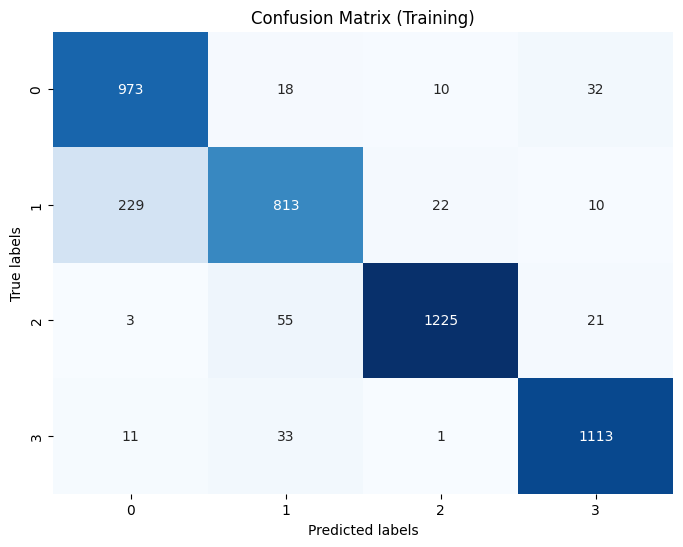

In [23]:
# Matriz de confusão
conf_matrix = confusion_matrix(train_labels, train_predictions_classes)

# Exibir a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Training)')
plt.show()

In [24]:
# Precisão, recall e F1-score
report = classification_report(train_labels, train_predictions_classes, target_names=label_encoder.classes_)
print("Relatório de Classificação:")
print(report)

Relatório de Classificação:
              precision    recall  f1-score   support

      glioma       0.80      0.94      0.87      1033
  meningioma       0.88      0.76      0.82      1074
     notumor       0.97      0.94      0.96      1304
   pituitary       0.95      0.96      0.95      1158

    accuracy                           0.90      4569
   macro avg       0.90      0.90      0.90      4569
weighted avg       0.91      0.90      0.90      4569

